### Deriving pulsar properties from PWNe - testing
* Pair-production multiplicity via de Jager 2007 $<k> = \frac{N_e({\rm obs})}{2N_{GJ}}$
* Initial spin-down period $P_0$ via van de Swaluw 2001 & the ratio $R_{pwn}/R_{snr}$
* Relate $k$ to the fraction of hadronic particles present in the PWN (and hence hadronic emission component) 

In [1]:
import numpy as np
import astropy.units as u
from astropy import constants as c
import matplotlib.pyplot as plt
from psrqpy import QueryATNF
import matplotlib.pylab as pylab
from cycler import cycler
from itertools import cycle
from scipy.integrate import simps

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

pylab.rcParams.update(params)
plt.style.use('tableau-colorblind10')

%matplotlib inline

In [2]:
# Choose parameters from ATNF (or query the whole database)
query = QueryATNF() #params=['Edot','age',"dist","P0","P1","BINARY"])

In [3]:
# Convert them to PANDAS
table = query.table
table = table.to_pandas()

age_all = table["AGE"]
edot_all = table["EDOT"]
dist = table["DIST"]
period = table["P0"]
pdot = table["P1"]
tau0atnf = np.asarray((-1*table["F0"]/table["F1"]))*u.s
fatnf = np.asarray(table["F0"])/u.s

# Compute beam fraction correction
beam_fraction = 9 * np.power(np.log10((period)/10), 2) + 3
beam_fraction /= 100

# Selection to remove milli-second pulsars
sel = np.logical_and(np.invert(np.isnan(age_all)), np.invert(np.isnan(edot_all)))
sel = np.logical_and(sel, dist < 25) #within the Milky Way
sel = np.logical_and(sel, period > 0.01)
sel = np.logical_and(sel, pdot > 1e-18)
sel = np.logical_and(sel, age_all < 1e7)

#print(max(age))
#Now apply selection mask 
age = age_all[sel]

edot = edot_all[sel]
beam_fraction = beam_fraction[sel]

### Pair-production mutiplicity
1) Use Halo paper results for known HESS PWNe to obtain $N_e$ via observations 
* i.e. use energy densities provided and properties of the assumed electron spectrum 
* Note: $E_{\rm min} = 100$GeV, $E_{\rm max}=1,3,10$TeV and $\Gamma = 2.2$

2) Use ATNF catalogue to obtain $N_{GJ}$ for the same pulsars via known properties
* see also eqn(2) of de Jager for the simplified version of $\dot{E}$


In [4]:
import pandas as pd

df = pd.read_csv("Pulsar_PWNe_properties - table_pulsars.csv")

In [5]:
df.columns

Index(['Name', 'ATNF J name', 'Edot [erg/s]', 'Size [pc]', 'Distance [kpc]',
       'Age [kyr]', 'Total_E [erg]', 'Volume [cm^3]', 'Edens [eV/cm^-3]',
       'mean_edens [eV/cm^-3]', 'min_edens [eV/cm^-3]', 'max_edens [eV/cm^-3]',
       'E_Threshold [TeV]', 'R_SNR [pc]', 'R_PWN [pc]', 'R_TeV [pc]',
       'R_Xray [pc]', 'LHAASO E_gmax (PeV)', 'LHAASO E_emax (PeV)',
       'Unnamed: 19', 'dN_e/dE', 'E_low [TeV]', 'E_0 [TeV]', 'E_max [TeV]',
       'N_e [cm^-3]', 'Notes'],
      dtype='object')

In [6]:
#Obtain period and pdot from ATNF
atnf_names=df['ATNF J name']
print(atnf_names)

period_atnf = np.zeros(len(df))
pdot_atnf = np.zeros(len(df))

for i in range(len(df)):
    psr_idx = np.where(query["NAME"]==atnf_names[i])[0][0]
    period_atnf[i] = period[psr_idx]
    pdot_atnf[i] = pdot[psr_idx]
    
print(period_atnf)

0     J0659+1414
1     J0633+1746
2     J1813-1749
3     J1833-1034
4     J1513-5908
5     J1930+1852
6     J1420-6048
7     J1849-0001
8     J1846-0258
9     J0835-4510
10    J1838-0655
11    J1418-6058
12    J1357-6429
13    J1826-1334
14    J1119-6127
15    J1301-6305
16    J0534+2200
17    J1747-2809
18    J0205+6449
19    J0007+7303
20    J1617-5055
21    J1023-5746
22    J1811-1925
23    J1856+0245
24    J1640-4631
25    J1640-4631
26    J1709-4429
27    J1907+0602
28    J1016-5857
29    J1016-5857
30    J1803-2137
31    J1809-1917
32    J1617-5055
33    J1718-3825
34    J1028-5819
35    J1833-0827
36    J1833-0827
37    J1857+0143
38    J1838-0537
39    J1837-0604
40    J1841-0345
41    J1844-0346
42    J1928+1746
43    J1954+2836
44    J1958+2846
45    J2021+3651
46    J2032+4127
47    J2229+6114
Name: ATNF J name, dtype: object
[0.38492862 0.23709944 0.04474056 0.06188365 0.15158194 0.13685505
 0.06817988 0.03852259 0.32657129 0.08932839 0.07049824 0.11057301
 0.16610833 0.101

In [7]:
#Define properties of electron spectrum as per the halos paper
E0 = 1. *u.TeV
E2 = 10. *u.TeV #1, 3 or 10
#E1 = 0.1 *u.TeV
E1 = df['E_Threshold [TeV]']*u.TeV
Gam = 2.2

pow2 = 2-Gam
integral2 = ((E2)**pow2 - (E1)**pow2)/(pow2*E0**(1-Gam))

#Integration constant is total energy (from halos paper) divided by electron spectrum integral
k_intconst = df["Total_E [erg]"]*u.erg / integral2

In [8]:
integral2

0          NaN
1          NaN
2     2.890652
3     2.887532
4     2.364768
5     1.958528
6     2.128713
7     2.586410
8     2.865963
9     2.660223
10    2.887532
11    2.128713
12    2.094579
13    2.862919
14    2.241386
15    2.224171
16         NaN
17         NaN
18         NaN
19         NaN
20    2.517885
21    2.152704
22         NaN
23    2.607263
24    2.732098
25    2.732098
26    2.770116
27    2.407359
28    2.131501
29    2.131501
30    2.903227
31    2.903227
32         NaN
33    2.884423
34    2.149847
35    2.887532
36    2.887532
37    2.607263
38         NaN
39         NaN
40    2.915961
41    2.915961
42         NaN
43         NaN
44         NaN
45         NaN
46         NaN
47         NaN
Name: E_Threshold [TeV], dtype: float64

In [9]:
pow1 = 1-Gam
integral = ((E2/E0)**pow1 - (E1/E0)**pow1)/pow1

Nel = k_intconst*integral
#Number of electrons derived from observations
print(Nel[0])

nan


In [10]:
#for convenience
yr_to_s = (1. * u.yr).to(u.s)

In [11]:
#Edot and age as used in halos paper: 
edot = np.zeros(len(df))
age_halo = np.zeros(len(df))

for i in range(len(df)):
#     print(i)
    edot[i] = df["Edot [erg/s]"][i] 
    age_halo[i] = df["Age [kyr]"][i]
    

edot *= u.erg / u.s
age_halo *= u.kyr
# print(age_halo)

In [12]:
#Just checking:
c.e.gauss

<<class 'astropy.constants.codata2018.EMCODATA2018'> name='Electron charge' value=4.803204712570263e-10 uncertainty=0.0 unit='Fr' reference='CODATA 2018'>

In [13]:
#Calculate age as a function of P0

def age_p0(psr_period,psr_pdot,p0=0.01*u.s,n=3):
    
    brk = n-1
    argp = p0/(psr_period*u.s)
    tau_age = 1. - argp**brk
    tau_age *= (psr_period*u.s)/(brk*psr_pdot)
    
    return tau_age.to(u.yr)

In [14]:
#Range of initial spin periods 
test_p0 = np.linspace(0.01,0.15,150)*u.s
print(test_p0)

[0.01       0.0109396  0.01187919 0.01281879 0.01375839 0.01469799
 0.01563758 0.01657718 0.01751678 0.01845638 0.01939597 0.02033557
 0.02127517 0.02221477 0.02315436 0.02409396 0.02503356 0.02597315
 0.02691275 0.02785235 0.02879195 0.02973154 0.03067114 0.03161074
 0.03255034 0.03348993 0.03442953 0.03536913 0.03630872 0.03724832
 0.03818792 0.03912752 0.04006711 0.04100671 0.04194631 0.04288591
 0.0438255  0.0447651  0.0457047  0.0466443  0.04758389 0.04852349
 0.04946309 0.05040268 0.05134228 0.05228188 0.05322148 0.05416107
 0.05510067 0.05604027 0.05697987 0.05791946 0.05885906 0.05979866
 0.06073826 0.06167785 0.06261745 0.06355705 0.06449664 0.06543624
 0.06637584 0.06731544 0.06825503 0.06919463 0.07013423 0.07107383
 0.07201342 0.07295302 0.07389262 0.07483221 0.07577181 0.07671141
 0.07765101 0.0785906  0.0795302  0.0804698  0.0814094  0.08234899
 0.08328859 0.08422819 0.08516779 0.08610738 0.08704698 0.08798658
 0.08892617 0.08986577 0.09080537 0.09174497 0.09268456 0.0936

In [15]:
#Calculate N_GJ integral

def calc_ngj(edot_pwn,age_pwn):
    
    ngj_integrand = (6. * c.c * edot_pwn)**0.5 
    ngj_integrand /= c.e.gauss
    ngj_out = ngj_integrand.to(1./u.s)*age_pwn.to(u.s)
        
    return ngj_out#.to(1.)

def calc_ngj(age_pwn,fatnf,tau0atnf,Bp=10**12*u.cm**-0.5*u.g**0.5/u.s,a=(10*u.km).to(u.cm),theta=np.pi/4):
    ys=np.arange(len(age_pwn),dtype='float64')
    for i in np.arange(len(ys)):
        t=np.linspace(0*u.s,age_pwn[i].to(u.s))
        edot_pwn=(2/(3*c.c.cgs**3))*(Bp**2*a**6/4)*((np.sin(theta)**2*fatnf**4)/(1+2*t/tau0atnf)**2)
        edot_pwn=edot_pwn.to(u.erg/u.s)
        integrand=1*(6*c.c.cgs*edot_pwn)**0.5/c.e.gauss
        y=simps(integrand,t)
        ys[i]=y
    return ys

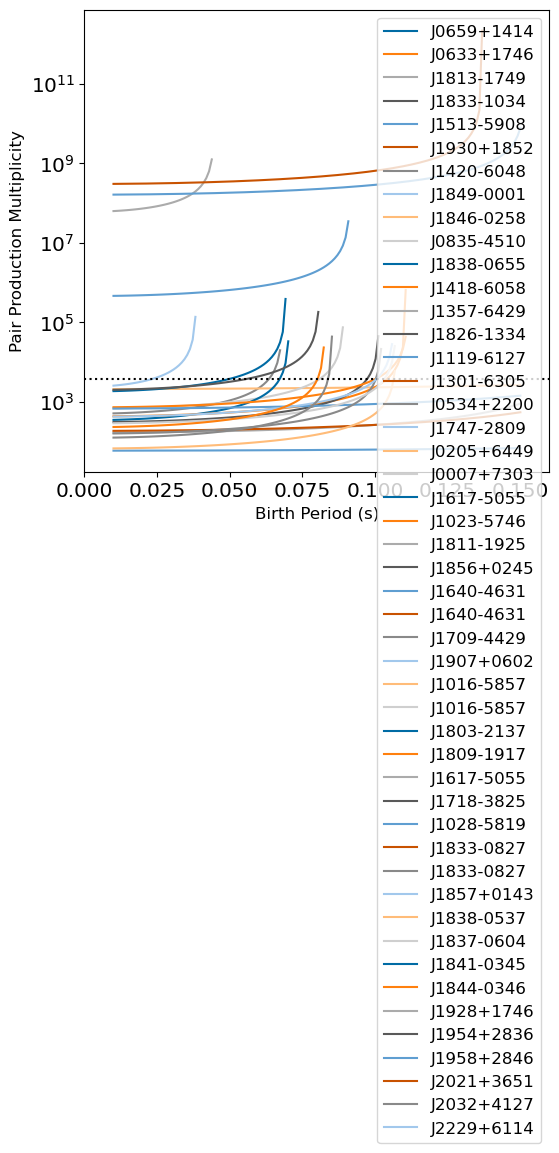

In [16]:
plt.figure(figsize=(6,6))

#Now plot how the pair-production multiplicity varies with P0. 

#Only first 10 in df, as len(df) is a crowded plot
for i in range(len(df)):
    
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
    ngj_p0 = calc_ngj(tau_p0,fatnf[i],tau0atnf[i])
    k_p0 = Nel[i] / (2.*ngj_p0)
    mask = test_p0 < period_atnf[i]*u.s
    plt.plot(test_p0[mask],k_p0[mask],label=atnf_names[i])
    
plt.semilogy()
#plt.ylim(100.,1e6)
plt.xlim(0.0,0.16)
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')
plt.ylabel("Pair Production Multiplicity",fontsize=12)
plt.xlabel("Birth Period (s)",fontsize=12)
plt.legend(fontsize=12)

None

In [17]:
# query.ppdot(showSNRs=True, showtypes='all')

### Maximum particle energy
From Emma et al. 2022 eqn (3):
Maximum energy as a function of spin-down power only
and eqn (4) - maximum gamma-ray energy based on electrons

In [18]:
#Equation 3
def Emax(Edot_psr,eta_e=1.,eta_b=1.):
    Edot_ref = 1e36*u.erg/u.s
    
    E_max = 2.*u.PeV * eta_e * eta_b**0.5 * (Edot_psr/Edot_ref)**0.5
    
    return E_max

#Equation 4
def Emax_gammae(Edot_psr,eta_e=1.,eta_b=1.):
    Edot_ref = 1e36*u.erg/u.s
    
    E_max = 0.9*u.PeV * eta_e**1.3 * eta_b**0.65 * (Edot_psr/Edot_ref)**0.65
    
    return E_max

In [19]:
Emax_psr = Emax(edot)
Emax_psrGamE = Emax_gammae(edot)

Emax_Echeck = 2.15*Emax_psrGamE**0.77 

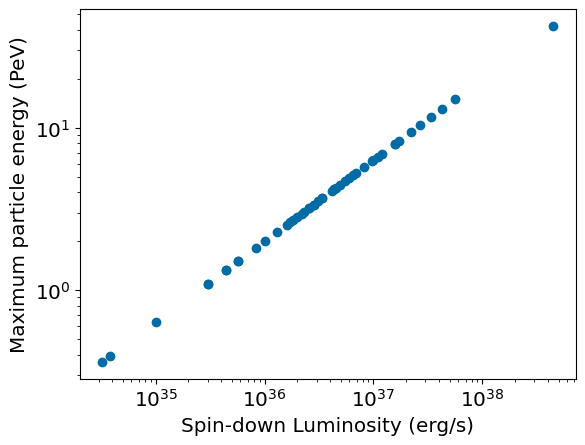

In [20]:
plt.scatter(edot,Emax_psr)
plt.semilogx()
plt.semilogy()
plt.xlabel("Spin-down Luminosity (erg/s)")
plt.ylabel("Maximum particle energy (PeV)")

None

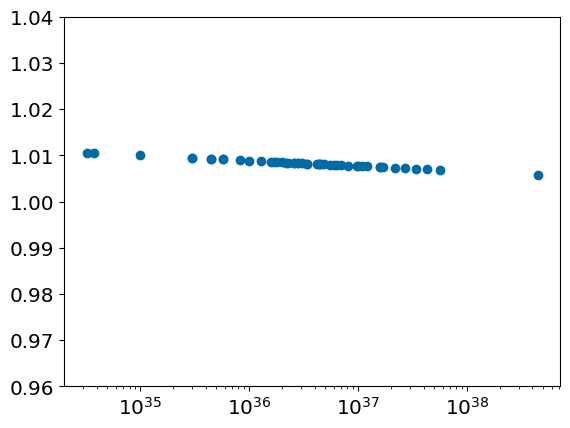

In [21]:
#Check consistency of Emax expressions via ratio
plt.scatter(edot,Emax_psr/Emax_Echeck)
plt.semilogx()
plt.ylim(0.96,1.04)

None

### Initial spin period
* Use eqn(6) of van der Swaluw - ratio of $R_{pwn}/R_{snr}$ can be obtained for e.g. table 1 of halo paper
 - doing this for the full table 2 will need a literature search
* Current spin period via ATNF catalogue
* Moment of inertia $I$ can be calculated, but $\eta_1$ and $\eta_3$ need to be assumed. 


Problem: $E_0$ - feels dangerous to assume this. 

Determine dependency of $P_0$ on assumed $E_0$? Or could assume a standard evolution of $\dot{E}$ towards present day values. 

In [22]:
#Expression for P0 from ratio based on van de Swaluw et al. 

def P0(R_pwn,R_snr,P_t,E0=1e51*u.erg,I=1.4e45*u.g*u.cm**2):
    eta_1 = 1.0
    eta_3 = 1.02
    R_ratio = R_pwn/(eta_3*R_snr)
    P_ratio = 2.*np.pi/P_t
    
    EI_term = 2.*E0 / (eta_1*I)
#     print(EI_term.to(1./u.s**2))
    
    P0 = (EI_term*R_ratio**3. + P_ratio**2)**-0.5
    P0 *= 2*np.pi
    
    return P0.to(u.s)

In [23]:
# atnf_names

In [24]:
#Reduced selection of PWNe (table 1 of halo paper)
bothradii = df['R_PWN [pc]'].notna()& df['R_SNR [pc]'].notna() & table["F0"].notna() & table["F1"].notna()
Ratnf = df['ATNF J name'][bothradii].to_numpy()#add J1825, Geminga
Rsnr = df['R_SNR [pc]'][bothradii].to_numpy()*u.pc #Assume Crab SNR size = PWN size
Rpwn = df['R_PWN [pc]'][bothradii].to_numpy()*u.pc #making a guess for J1825
print(Ratnf)

['J1513-5908' 'J1930+1852' 'J1846-0258' 'J0835-4510' 'J1747-2809']


In [25]:
Patnf = np.zeros(len(Ratnf))
for i in range(len(Ratnf)):
    index = np.where(atnf_names==Ratnf[i])[0][0]
    Patnf[i] = period_atnf[index]

print(Patnf)

[0.15158194 0.13685505 0.32657129 0.08932839 0.05215285]


In [26]:
P_0 = P0(Rpwn,Rsnr,Patnf*u.s)

In [27]:
# print(P_0,Patnf)
#Ratio of P0 derived to current period in ATNF:
print(P_0 / (Patnf*u.s))

[0.10053579 0.30180072 0.1554733  0.12159543 0.91797585]


Now we have both $k$ as a function of $P_0$, for all pulsars/pwne considered in the halos paper, and constraints on $P_0$ for a subset of pwne for which we have more information (e.g. table 1 of the halos paper). 

Dashed lines below indicate the evaluated $P_0$ from the radius ratio. 
Where the lines of the same colour intersect, this gives the pair-production multiplicity for that PWN. 


J1513-5908 p= 0.15158194339345915 P0= 0.015239410525787624 s 150 kappa= 164224054.26522726
J1930+1852 p= 0.136855046957 P0= 0.04130295131654276 s 136 kappa= 332414333.831969
J1846-0258 p= 0.3265712883437141 P0= 0.0507731171134841 s 150 kappa= 2115.4330877362254
J0835-4510 p= 0.08932838502359318 P0= 0.010861923156129938 s 85 kappa= 675.0710170536245
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]


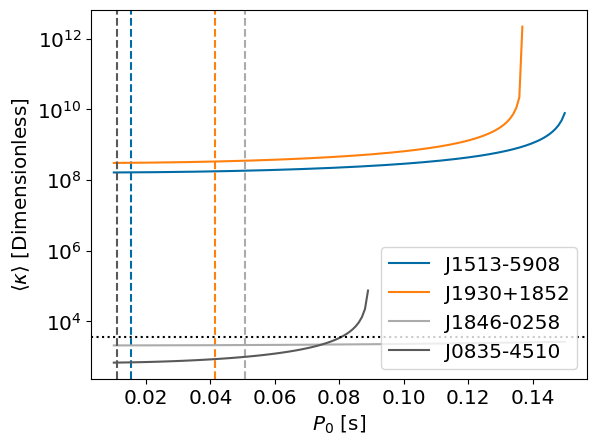

In [28]:
#Add these derived P0s to the plot above of k vs P0. 

for index in range(len(Ratnf)):#len(df)):

    i = np.where(atnf_names==Ratnf[index])[0][0]
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
    ngj_p0 = calc_ngj(tau_p0,fatnf[i],tau0atnf[i])

    k_p0 = Nel[i] / (2.*ngj_p0)
    mask = test_p0 < period_atnf[i]*u.s
    if np.isnan(k_p0[np.abs(P_0[index].value-test_p0[mask].value).argmin()]):
        continue
    print(Ratnf[index],"p=",period_atnf[i],"P0=",P_0[index],sum(mask),'kappa=',k_p0[np.abs(P_0[index].value-test_p0[mask].value).argmin()])
    p = plt.plot(test_p0[mask],k_p0[mask],label=Ratnf[index])
    plt.axvline(P_0[index].value,linestyle='--',color=p[0].get_color())
    
plt.semilogy()
#plt.ylim(100.,1e6)
#plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.legend(ncols=1,loc=4)
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')
plt.savefig('kappaplot.png',dpi=300)

J1513-5908 p= 0.15158194339345915 P0= 0.015239410525787624 s 150 kappa= 164224054.26522726
J1513-5908 0.015239410525787624 s 0.015239410525787624 s 0.03827537618747317 s
J1930+1852 p= 0.136855046957 P0= 0.04130295131654276 s 136 kappa= 332414333.831969
J1930+1852 0.04130295131654276 s 0.04130295131654276 s 0.04130295131654276 s
J1846-0258 p= 0.3265712883437141 P0= 0.0507731171134841 s 150 kappa= 2115.4330877362254
J1846-0258 0.0507731171134841 s 0.0507731171134841 s 0.0507731171134841 s
J0835-4510 p= 0.08932838502359318 P0= 0.010861923156129938 s 85 kappa= 675.0710170536245
J0835-4510 0.010861923156129938 s 0.010861923156129938 s 0.062054804358874636 s
J1747-2809 p= 0.052152855 P0= 0.04787506158892769 s 45 kappa= nan
J1747-2809 0.04787506158892769 s 0.04787506158892769 s 0.03362466490440795 s


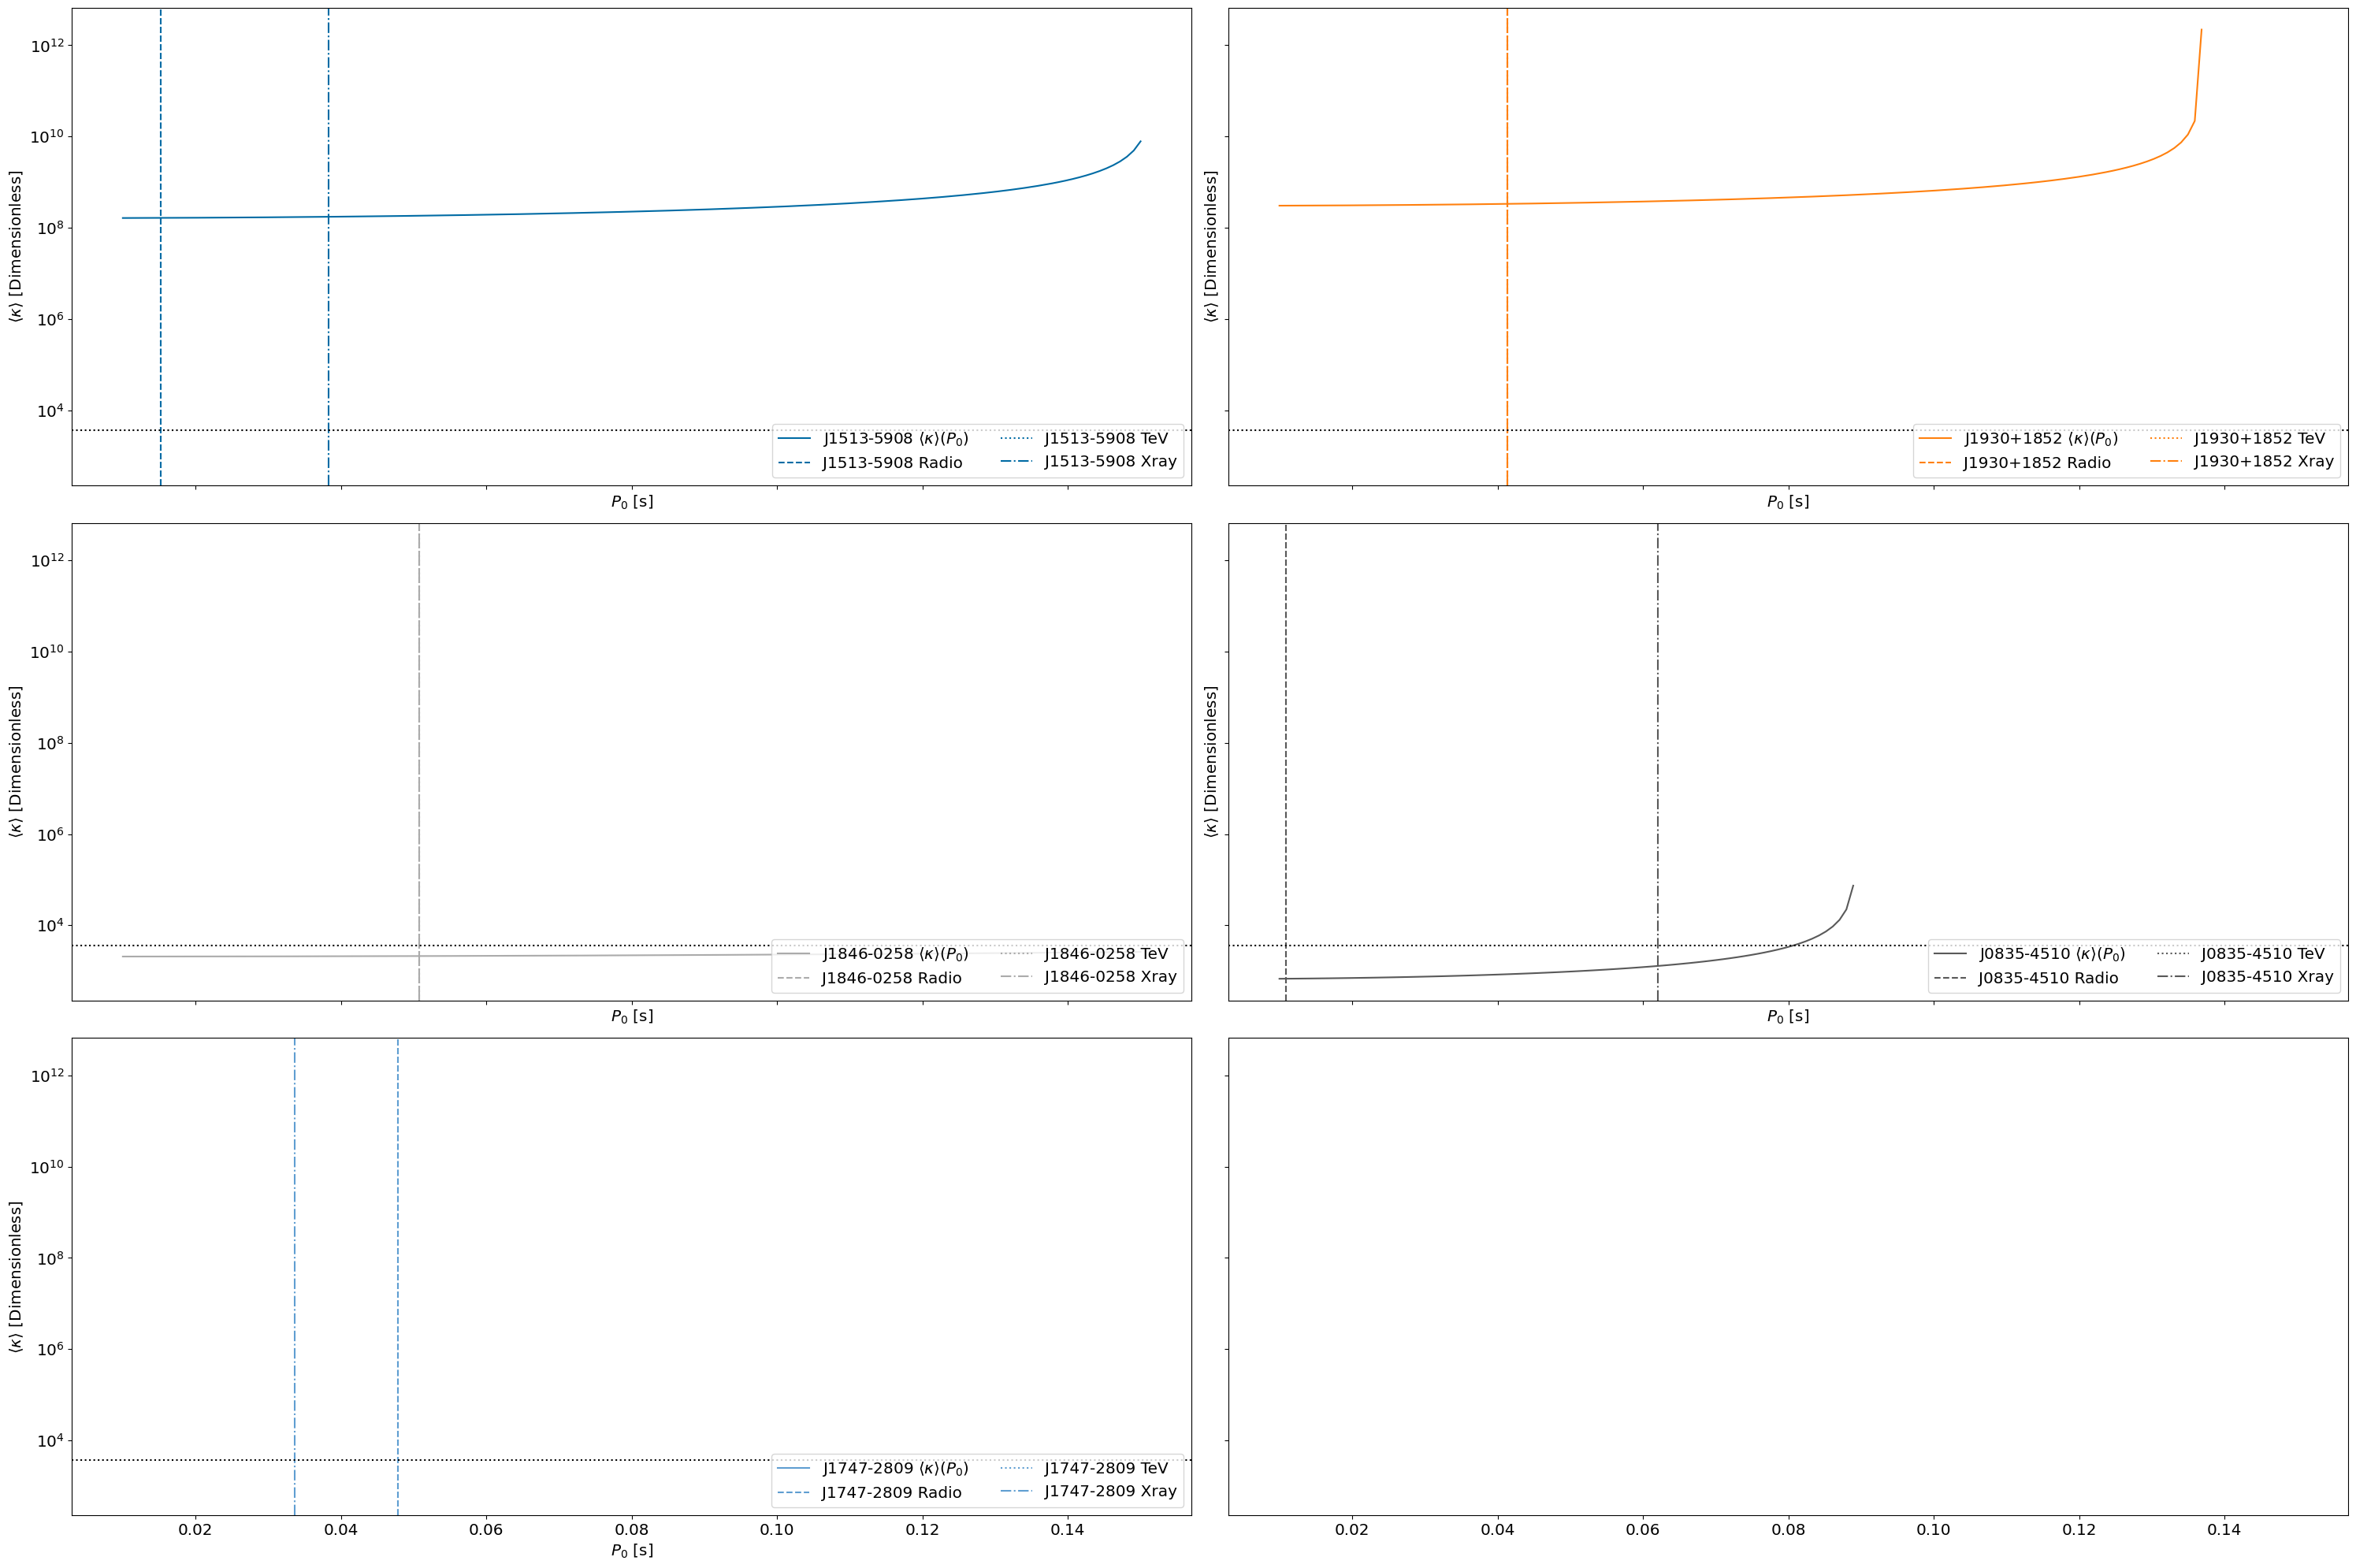

In [29]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = cycle(prop_cycle.by_key()['color'])


R_TeV=df['R_PWN [pc]'][bothradii].to_numpy()*u.pc
R_Xray=df['R_Xray [pc]'][bothradii].to_numpy()*u.pc

P_0 = P0(Rpwn,Rsnr,Patnf*u.s)
P_TeV = P0(R_TeV,Rsnr,Patnf*u.s)
P_Xray = P0(R_Xray,Rsnr,Patnf*u.s)
fig,axs=plt.subplots(3,2,sharex=True,sharey=True,figsize=(30,20))
axs=axs.reshape(-1)
for index in range(len(Ratnf)):#len(df)):
    mycol=next(colors)
    i = np.where(atnf_names==Ratnf[index])[0][0]
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
    ngj_p0 = calc_ngj(tau_p0,fatnf[i],tau0atnf[i])

    k_p0 = Nel[i] / (2.*ngj_p0)
    mask = test_p0 < period_atnf[i]*u.s
    print(Ratnf[index],"p=",period_atnf[i],"P0=",P_0[index],sum(mask),'kappa=',k_p0[np.abs(P_0[index].value-test_p0[mask].value).argmin()])
    
    p = axs[index].plot(test_p0[mask],k_p0[mask],color=mycol, label=Ratnf[index]+r' $\langle \kappa \rangle (P_0)$')
    axs[index].axvline(P_0[index].value,linestyle='--',label=Ratnf[index]+' Radio',color=mycol)
    axs[index].axvline(P_TeV[index].value,linestyle=':',label=Ratnf[index]+' TeV',color=mycol)
    axs[index].axvline(P_Xray[index].value,linestyle='-.',label=Ratnf[index]+' Xray',color=mycol)
    print(Ratnf[index],P_0[index],P_TeV[index],P_Xray[index])
    
    axs[index].semilogy()
    #axs[index].set_ylim(100.,1e6)
    #axs[index].set_xlim(0.0,0.16)
    axs[index].set_ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
    axs[index].set_xlabel("$P_0\ \mathrm{[s]}$")
    axs[index].legend(ncols=2,loc=4)
    axs[index].axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')
plt.tight_layout()
plt.savefig('rplot.png',dpi=300)

In [30]:
2*c.m_p/c.m_e

<Quantity 3672.30534688>

The desired pair-production multiplicity for hadrons from the pulsar surface to reach the PWN is that 
$k \lesssim 2m_p/m_e = 3672 $ which is given by the horizontal dotted line. 

We can therefore exclude the PWNe studied here as being systems in which that could have happened, with the possible exception of Vela and J1825-137. 

In [31]:
E0range=np.linspace(0.1,10,5)*u.TeV
E2 = 10. *u.TeV #1, 3 or 10
E1 = 0.1 *u.TeV
Gam = 2.2
pow2 = 2-Gam
pow1 = 1-Gam


for index in range(len(E0range)):#len(df)):
    E0 = E0range[index]
    integral2 = ((E2)**pow2 - (E1)**pow2)/(pow2*E0**(1-Gam))
    integral = ((E2/E0)**pow1 - (E1/E0)**pow1)/pow1
    k_intconst = df["Total_E [erg]"]*u.erg / integral2
    Nel = k_intconst*integral
    print(Nel[i])
    i = np.where(atnf_names=='J1746-0258')[0][0]
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
    ngj_p0 = calc_ngj(tau_p0,fatnf[i],tau0atnf[i])

    k_p0 = Nel[i] / (2.*ngj_p0)
    mask = test_p0 < period_atnf[i]*u.s
    p = plt.plot(test_p0[mask],k_p0[mask],label='%.1f'%E0range[index].value+' TeV')
    
plt.semilogy()
#plt.ylim(100.,1e6)
plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.legend(title='$E_0$',ncols=3,loc=4,title_fontsize='x-large')
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')

plt.tight_layout()
plt.savefig('e0scan.png',dpi=300)

1.9692251953896415e+49


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
E2=10*u.TeV
E0 = 1 *u.TeV #1, 3 or 10
E1 = 0.1 *u.TeV
Gamrange = np.asarray([1.6,2.2,2.8]) #try 1.6-2.6



for index in range(len(Gamrange)):#len(df)):
    Gam = Gamrange[index]
    pow2 = 2-Gam
    pow1 = 1-Gam
    integral2 = ((E2)**pow2 - (E1)**pow2)/(pow2*E0**(1-Gam))
    integral = ((E2/E0)**pow1 - (E1/E0)**pow1)/pow1
    k_intconst = df["Total_E [erg]"]*u.erg / integral2
    Nel = k_intconst*integral
    print(Nel[i])
    i = np.where(atnf_names=='J1747-2809')[0][0]
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
    ngj_p0 = calc_ngj(tau_p0,fatnf[i],tau0atnf[i])

    k_p0 = Nel[i] / (2.*ngj_p0)
    mask = test_p0 < period_atnf[i]*u.s
    p = plt.plot(test_p0[mask],k_p0[mask],label='%.1f'%Gamrange[index])
    
plt.semilogy()
plt.ylim(100.,1e6)
#plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')
plt.legend(title='$\Gamma$',ncols=3,loc=4,title_fontsize='x-large')
plt.tight_layout()
plt.savefig('gamscan.png',dpi=300)

In [ ]:
E2range=np.asarray([1,3,10])*u.TeV
E0 = 1 *u.TeV #1, 3 or 10
E1 = 0.1 *u.TeV
Gam = 2.2
pow2 = 2-Gam
pow1 = 1-Gam


for index in range(len(E2range)):#len(df)):
    E2 = E2range[index]
    integral2 = ((E2)**pow2 - (E1)**pow2)/(pow2*E0**(1-Gam))
    integral = ((E2/E0)**pow1 - (E1/E0)**pow1)/pow1
    k_intconst = df["Total_E [erg]"]*u.erg / integral2
    Nel = k_intconst*integral
    print(Nel[i])
    i = np.where(atnf_names=='J1747-2809')[0][0]
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
    ngj_p0 = calc_ngj(tau_p0,fatnf[i],tau0atnf[i])

    k_p0 = Nel[i] / (2.*ngj_p0)
    mask = test_p0 < period_atnf[i]*u.s
    p = plt.plot(test_p0[mask],k_p0[mask],label='%.0f'%E2range[index].value+' TeV')
    
plt.semilogy()
#plt.ylim(100.,1e6)
#plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')
plt.legend(title='$E_2$',ncols=3,loc=4,title_fontsize='x-large')
plt.tight_layout()
plt.savefig('e2scan.png',dpi=300)

In [ ]:
E2=10*u.TeV
E0 = 1 *u.TeV #1, 3 or 10
E1 = 0.1 *u.TeV
Gam = 2.2
pow2 = 2-Gam
pow1 = 1-Gam
Irange=np.linspace(1e45,3e45,3)*u.g*u.cm**2
fig=plt.figure(figsize=(10,6))
for index in range(len(Irange)):#len(df)):
    P_0dup = P0(Rpwn,Rsnr,Patnf*u.s,I=Irange[index])

    integral2 = ((E2)**pow2 - (E1)**pow2)/(pow2*E0**(1-Gam))
    integral = ((E2/E0)**pow1 - (E1/E0)**pow1)/pow1
    k_intconst = df["Total_E [erg]"]*u.erg / integral2
    Nel = k_intconst*integral
    i = np.where(atnf_names=='J1747-2809')[0][0]
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
    ngj_p0 = calc_ngj(tau_p0,fatnf[i],tau0atnf[i])

    k_p0 = Nel[i] / (2.*ngj_p0)
    mask = test_p0 < period_atnf[i]*u.s
    plt.axvline(P_0dup[index].value,linestyle='--',label=str(Irange[index].value)+'$\mathrm{\,g\,cm^2}$',color=next(colors))


    

p = plt.plot(test_p0[mask],k_p0[mask])
    
plt.semilogy()
#plt.ylim(100.,1e6)
#plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')
plt.legend(title='$I$',ncols=3,loc=4,title_fontsize='x-large')
plt.tight_layout()
plt.savefig('I.png',dpi=300)

In [ ]:
#Dragonfly, J2018+3651 from https://arxiv.org/pdf/1907.12121.pdf
#Approach, numerically integrate power law with exponential cutoff.

x=np.linspace(1e-6,1e3,100)*u.TeV #Lower bound is 1 MeV.
E0=1*u.TeV #Pivot energy is 1 TeV
Ecut=0.9*u.PeV #Cutoff is 900 TeV
completeenergy=(x/E0)**-1.4*np.exp(-x/Ecut)#alpha is 2.4
kconst=6.1e49*u.erg/simps(completeenergy,x) #Calculate electron spectrum normalisation
y=kconst*(x/E0)**-2.4*np.exp(-x/Ecut) #Electron Spectrum
nel=simps(kconst*(x/E0)**-2.4*np.exp(-x/Ecut),x) #Integrate dN/dE
i=np.where(atnf_names=='J2021+3651')[0][0] #Locate pulsar and calculate ngj
tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
ngj_p0 = calc_ngj(tau_p0,fatnf[i],tau0atnf[i])
print(nel)
k_p0 = nel / (2.*ngj_p0)
mask = test_p0 < period_atnf[i]*u.s
plt.plot(test_p0[mask],k_p0[mask],label=atnf_names[i])
plt.semilogy()
#plt.ylim(100.,1e8)
plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')

In [ ]:
from scipy.integrate import simps
from scipy.special import gammainc
#Dragonfly, J2018+3651 from https://arxiv.org/pdf/1907.12121.pdf
#Approach, try instead analytic form for integral of power law with exponential cutoff.
E1=1*u.MeV
x=np.linspace(1e-6,1e3,100)*u.TeV #Lower bound is 1 MeV. -6
E0=1*u.TeV #Pivot energy is 1 TeV
Ecut=0.9*u.PeV #Cutoff is 900 TeV

completeenergy=(E1)**-2.4*Ecut*(-E1/Ecut)**-2.4*gammainc(-1.4,-(E1/Ecut).value)#alpha is 2.4
print(completeenergy)
#kconst=6.1e49*u.erg/simps(completeenergy,x) #Calculate electron spectrum normalisation
#y=kconst*(x/E0)**-2.4*np.exp(-x/Ecut) #Electron Spectrum
#nel=simps(kconst*(x/E0)**-2.4*np.exp(-x/Ecut),x) #Integrate dN/dE

i=np.where(atnf_names=='J2021+3651')[0][0] #Locate pulsar and calculate ngj
tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
ngj_p0 = calc_ngj(tau_p0,fatnf[i],tau0atnf[i])
print(nel)
k_p0 = nel / (2.*ngj_p0)
mask = test_p0 < period_atnf[i]*u.s
plt.plot(test_p0[mask],k_p0[mask],label=atnf_names[i])
plt.semilogy()
#plt.ylim(100.,1e8)
plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')

In [ ]:
#J1843-0338
#x=np.linspace(1e-5,10,100)*u.TeV #-5
x=np.linspace(0.379,10,100)*u.TeV #Value from HESS GPS
E0=7*u.TeV
Ecut=92.20*u.TeV

kconst=8.03*10**33/u.eV
nel=simps(kconst*(x/E0)**-2.37*np.exp(-x/Ecut),x)
i=np.where(atnf_names=='J1841-0345')[0][0]
tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
ngj_p0 = calc_ngj(tau_p0,fatnf[i],tau0atnf[i])
print(nel,ngj_p0)
k_p0 = nel / (2.*ngj_p0)
mask = test_p0 < period_atnf[i]*u.s
plt.plot(test_p0[mask],k_p0[mask],label=atnf_names[i])
plt.semilogy()
#plt.ylim(100.,1e8)
plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')

In [ ]:
#J1849-000
E0=10*u.TeV
#E1=0.1*u.TeV From paper in final column
E1=0.501*u.TeV #From H.E.S.S. GPS
E2=10*u.TeV
kconst=10**31.98/u.eV
gam1=-2.46

nel=kconst*((E2/E0).to(u.eV/u.eV)**(gam1+1)-(E1/E0).to(u.eV/u.eV)**(gam1+1))/(gam1+1)
i=np.where(atnf_names=='J1849-0001')[0][0]
tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
ngj_p0 = calc_ngj(tau_p0,fatnf[i],tau0atnf[i])
print(nel,ngj_p0)

k_p0 = nel / (2.*ngj_p0)
mask = test_p0 < period_atnf[i]*u.s
plt.plot(test_p0[mask],k_p0[mask],label=atnf_names[i])
plt.semilogy()
#plt.ylim(100.,1e8)
plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')

In [ ]:
#J1825-137

#e1=1*u.TeV 
e1=0.396*u.TeV #HESS GPS
ebreak=0.9*u.TeV
gam1=-1.4
gam2=-3.25
Etot=5.5e48*u.erg
x1=np.linspace(0.7,ebreak.value,100)*u.TeV
x2=np.linspace(ebreak.value,12,100)*u.TeV
y1=x1**(gam1+1)/gam1
y2=x2**(gam2+1)/gam2
z1=x1**gam1
z2=x2**gam2

kprop=Etot/(simps(y2,x2)+simps(y1,x1))
nel=kprop*(simps(x2,z2)+simps(x1,z1))

i=np.where(atnf_names=='J1826-1334')[0][0]
tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
ngj_p0 = calc_ngj(tau_p0,fatnf[i],tau0atnf[i])
k_p0 = nel / (2.*ngj_p0)
mask = test_p0 < period_atnf[i]*u.s
plt.plot(test_p0[mask],k_p0[mask],label=atnf_names[i])
plt.semilogy()
#plt.ylim(100.,1e8)
plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')
